Tensor Field Networks

Implementation of moment of inertia demonstration

In [1]:
from math import pi, sqrt
import numpy as np
import tensorflow as tf
import random
import tensorfieldnetworks.layers as layers
import tensorfieldnetworks.utils as utils
from tensorfieldnetworks.utils import EPSILON, FLOAT_TYPE

In [2]:
num_points = 15

# radial basis functions
rbf_low = 0.
rbf_high = 2.
rbf_count = 30
rbf_spacing = (rbf_high - rbf_low) / rbf_count
centers = tf.cast(tf.lin_space(rbf_low, rbf_high, rbf_count), FLOAT_TYPE)

In [3]:
def matrix_from_0_2(input_0, input_2):
    """
    inputs:
    -shape [N] tensor, L=0 feature at each point
    -shape [N, 5] tensor, L=2 feature vector at each point
    
    returns:
    -shape [N, 3, 3] tensor, matrix at each point
    """
    d_xy = input_2[:,0]
    d_yz = input_2[:,1]
    d_z2 = input_2[:,2]   # -x^2 - y^2 + 2*z^2
    d_zx = input_2[:,3]
    d_x2y2 = input_2[:,4] # x^2 - y^2
    Mxx = - d_z2 / sqrt(3.) + d_x2y2 + input_0
    Myy = - d_z2 / sqrt(3.) - d_x2y2 + input_0
    Mzz = 2*d_z2 / sqrt(3.) + input_0
    
    # rows : [N, 3]
    row0 = tf.stack([Mxx, d_xy, d_zx], axis=-1)
    row1 = tf.stack([d_xy, Myy, d_yz], axis=-1)
    row2 = tf.stack([d_zx, d_yz, Mzz], axis=-1)
    
    # [N, 3, 3]
    return tf.stack([row0, row1, row2], axis=-2)

In [4]:
# r : [N, 3]
r = tf.placeholder(FLOAT_TYPE, shape=(num_points, 3))

# masses_input : [N]
masses_input = tf.placeholder(FLOAT_TYPE, shape=(num_points))

# rij : [N, N, 3]
rij = utils.difference_matrix(r)

# dij : [N, N]
dij = utils.distance_matrix(r)

# rbf : [N, N, rbf_count]
gamma = 1. / rbf_spacing
rbf = tf.exp(-gamma * tf.square(tf.expand_dims(dij, axis=-1) - centers))

output_dim = 1

masses = tf.reshape(masses_input, [-1, 1, 1])

# shifted softplus
nonlin=utils.ssp

# single layer, 0 -> 0 + 2
with tf.variable_scope(None, "layer1", values=[masses]):
    with tf.variable_scope(None, "F0", values=[masses]):
        layer_0_ = layers.filter_0(masses, rbf, output_dim=output_dim, nonlin=nonlin)
        output_0 = tf.squeeze(layer_0_)
    with tf.variable_scope(None, "F2", values=[masses]):
        layer_2_ = layers.filter_2_output_2(masses, rbf, rij, output_dim=output_dim, nonlin=nonlin)
        output_2 = tf.squeeze(layer_2_)

# output : [N, 3, 3]
output = matrix_from_0_2(output_0, output_2)

# truth : [N, 3, 3]
truth = tf.placeholder(FLOAT_TYPE)

# tf_index : []
tf_index = tf.placeholder(tf.int32)

# loss : []
loss = tf.nn.l2_loss(output[tf_index] - truth)

optim = tf.train.AdamOptimizer(learning_rate=1.e-4)

train_op = optim.minimize(loss)

In [5]:
def random_points_and_masses(num_points=num_points, max_coord=rbf_high/4., min_mass=0.5, max_mass=2.0):
    """
    returns:
    -shape [num_points, 3] numpy array of points
    -shape [num_points] numpy array of masses
    """
    output_points = []
    for point in xrange(num_points):
        output_points.append(np.array([random.uniform(-max_coord, max_coord) for _ in range(3)]))
    
    points = np.array(output_points)
    masses = np.random.rand(len(output_points)) * (max_mass - min_mass) + min_mass
    return points, masses


def moi_tensor(points, masses, index):
    """
    inputs:
    -shape [N] tensor, L=0 feature at each point
    -shape [N, 5] tensor, L=2 feature vector at each point
    
    returns:
    -shape [N, 3, 3] tensor, matrix at each point
    """
    center = points[index]
    moi = np.full((3, 3), 0.)
    for point, mass in zip(points, masses):
        x, y, z = point - center
        Ixx = y**2 + z**2
        Iyy = x**2 + z**2
        Izz = x**2 + y**2
        Ixy = -x*y
        Iyz = -y*z
        Ixz = -x*z
        moi += np.array([[Ixx, Ixy, Ixz], 
                         [Ixy, Iyy, Iyz],
                         [Ixz, Iyz, Izz]]) * mass
    return moi

In [6]:
# for plotting

# x : []
x = tf.placeholder(tf.float32, shape=(None))

# rbf_plot : [rbf_count]
rbf_plot = tf.exp(-gamma * tf.pow(x - centers, 2))

for v in tf.global_variables():
    if 'layer1/F0/F0_to_L/F_0/radial_function/weights1' in v.name and "Adam" not in v.name:
        f0_w1 = v
    elif 'layer1/F0/F0_to_L/F_0/radial_function/biases1' in v.name and "Adam" not in v.name:
        f0_b1 = v
    elif 'layer1/F0/F0_to_L/F_0/radial_function/weights2' in v.name and "Adam" not in v.name:
        f0_w2 = v
    elif 'layer1/F0/F0_to_L/F_0/radial_function/biases2' in v.name and "Adam" not in v.name:
        f0_b2 = v
    elif 'layer1/F2/F2_to_2/F_2/radial_function/weights1' in v.name and "Adam" not in v.name:
        f2_w1 = v
    elif 'layer1/F2/F2_to_2/F_2/radial_function/biases1' in v.name and "Adam" not in v.name:
        f2_b1 = v
    elif 'layer1/F2/F2_to_2/F_2/radial_function/weights2' in v.name and "Adam" not in v.name:
        f2_w2 = v
    elif 'layer1/F2/F2_to_2/F_2/radial_function/biases2' in v.name and "Adam" not in v.name:
        f2_b2 = v
        
F0_hidden_layer_plot = nonlin(f0_b1 + tf.tensordot(rbf_plot, f0_w1, [[0], [1]]))
F0_R_plot = f0_b2 + tf.tensordot(F0_hidden_layer_plot, f0_w2, [[0], [1]])

F2_hidden_layer_plot = nonlin(f2_b1 + tf.tensordot(rbf_plot, f2_w1, [[0], [1]]))
F2_R_plot = f2_b2 + tf.tensordot(F2_hidden_layer_plot, f2_w2, [[0], [1]])

In [7]:
max_steps = 10001
print_freq = 1000
validation_size = 1000

x_vals = [index * rbf_high / rbf_count for index in xrange(rbf_count)]

sess = tf.Session()
sess.run(tf.global_variables_initializer())


# training
for step in xrange(max_steps):
    shape, rand_masses = random_points_and_masses()
    center_index = 0
    # make center point index have zero mass
    rand_masses[center_index] = 0.0
    loss_value, _ = sess.run([loss, train_op], feed_dict={r: shape, 
                                                          tf_index: center_index, 
                                                          truth: moi_tensor(shape, rand_masses, center_index), 
                                                          masses_input: rand_masses})
    

    if step % print_freq == 0:
        loss_sum = 0.
        for example in xrange(validation_size):
            shape, rand_masses = random_points_and_masses()
            rand_masses[center_index] = 0.0
            moi = moi_tensor(shape, rand_masses, center_index)
            loss_value = sess.run(loss, feed_dict={r: shape, 
                                                     tf_index: center_index, 
                                                     truth: moi, 
                                                     masses_input: rand_masses})
            loss_sum += loss_value
        print("Step %d: validation loss = %.3f" % (step, loss_sum / validation_size))
        
    if step == max_steps - 1:
        y_vals = []
        for x_val in x_vals:
            y_vals.append(sess.run(F0_R_plot, feed_dict={x: x_val}))
        F0_y_vals = y_vals
        
        y_vals = []
        for x_val in x_vals:
            y_vals.append(sess.run(F2_R_plot, feed_dict={x: x_val}))
        F2_y_vals = y_vals

Step 0: validation loss = 136.885
Step 1000: validation loss = 2.380
Step 2000: validation loss = 0.226
Step 3000: validation loss = 0.056
Step 4000: validation loss = 0.017
Step 5000: validation loss = 0.007
Step 6000: validation loss = 0.006
Step 7000: validation loss = 0.004
Step 8000: validation loss = 0.005
Step 9000: validation loss = 0.002
Step 10000: validation loss = 0.002


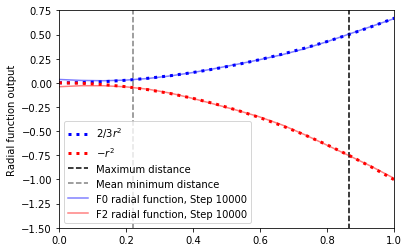

In [8]:
# plot radial functions vs analytic solution

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(1, sharex=True)

ax1.plot(x_vals, [2./3. * r_**2 for r_ in x_vals], "b:", lw=3, label="$2/3 r^2$")
ax1.plot(x_vals, [-r_**2 for r_ in x_vals], "r:", lw=3, label="$-r^2$")
ax1.plot([np.sqrt(3 * (rbf_high/4)**2), np.sqrt(3 * (rbf_high/4)**2)], [-4,4], '--', 
         color="#000000", label="Maximum distance")
ax1.plot([0.22, 0.22], [-4,4], '--', color="#818181", label="Mean minimum distance")

F0_y_vals_reshape = np.reshape(np.array(F0_y_vals), np.array(F0_y_vals).shape[0])
ax1.plot(x_vals, F0_y_vals_reshape, 'b-', label="F0 radial function, Step {}".format(step), alpha=0.5)

F2_y_vals_reshape = np.reshape(np.array(F2_y_vals), np.array(F2_y_vals).shape[0])
ax1.plot(x_vals, F2_y_vals_reshape,'r-', label="F2 radial function, Step {}".format(step), alpha=0.5)
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels)

ax1.set_xlim(0,1)
ax1.set_ylim(-1.5,0.75)
ax1.set_ylabel("Radial function output")
plt.show()